"Disinformation is often worse than no information at all..." - Ibiki Morino, Naruto

In [73]:
import pandas as pd
import numpy as np
import nltk 
import re
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
import sklearn.metrics
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report,confusion_matrix,mean_squared_error
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, average_precision_score
sns.set_style("darkgrid")
sns.set_palette("Set2", 8, 0.5)

%run -i "Functions/print_metrics.py"

In [2]:
# Load dataset
df = pd.read_csv('news_articles.csv')

df.head()

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0


In [3]:
df.site_url.value_counts()

activistpost.com       100
infowars.com           100
clickhole.com          100
presstv.ir             100
naturalnews.com        100
                      ... 
redstatewatcher.com      1
therussophile.org        1
projectveritas.com       1
madworldnews.com         1
allnewspipeline.com      1
Name: site_url, Length: 68, dtype: int64

In [4]:
df.isnull().sum()

author                      0
published                   0
title                       0
text                       46
language                    1
site_url                    1
main_img_url                1
type                        1
label                       1
title_without_stopwords     2
text_without_stopwords     50
hasImage                    1
dtype: int64

In [5]:
df['text_without_stopwords'][0]

'print pay back money plus interest entire family everyone came need deported asap take two years bust go another group stealing government taxpayers group somalis stole four million government benefits months weve reported numerous cases like one muslim refugeesimmigrants commit fraud scamming systemits way control related'

In [6]:
# Author does not look like a useful column... also would lead to overfitting
df['author'].value_counts()

No Author                              505
Activist Post                           82
EdJenner                                73
noreply@blogger.com (Der Postillon)     72
Anonymous                               58
                                      ... 
T. Mohr                                  1
Jacques de Seingalt                      1
tapatio                                  1
Phyllis Bentley                          1
Rafiq                                    1
Name: author, Length: 491, dtype: int64

In [70]:
# Dropping the 50 or so rows with NaN for tezt
df = df[df['text'].notna()]

In [8]:
df.text.isnull().sum()

0

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2050 entries, 0 to 2049
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   author                   2050 non-null   object 
 1   published                2050 non-null   object 
 2   title                    2050 non-null   object 
 3   text                     2050 non-null   object 
 4   language                 2050 non-null   object 
 5   site_url                 2050 non-null   object 
 6   main_img_url             2050 non-null   object 
 7   type                     2050 non-null   object 
 8   label                    2050 non-null   object 
 9   title_without_stopwords  2049 non-null   object 
 10  text_without_stopwords   2046 non-null   object 
 11  hasImage                 2050 non-null   float64
dtypes: float64(1), object(11)
memory usage: 208.2+ KB


In [10]:
# Our primary analysis will be on predicting labels "Real" & "Fake" using the text provided
# A secondary analysis could be to attempt to run multiclassification on the predicting the types with text
# It will be interesting. to analyze the given "type" analysis with our own sentiment analysis
text = df[['label', 'type', 'text', 'title', 'author', 'site_url', 'text_without_stopwords']]

In [11]:
# About 50 rows with null values to drop...
text = text.dropna(axis=0)

In [12]:
text.head()

,label,type,text,title,author,site_url,text_without_stopwords
0,Real,bias,print they should pay all the back all the mon...,muslims busted they stole millions in govt ben...,Barracuda Brigade,100percentfedup.com,print pay back money plus interest entire fami...
1,Real,bias,why did attorney general loretta lynch plead t...,re why did attorney general loretta lynch plea...,reasoning with facts,100percentfedup.com,attorney general loretta lynch plead fifth bar...
2,Real,bias,red state \nfox news sunday reported this mor...,breaking weiner cooperating with fbi on hillar...,Barracuda Brigade,100percentfedup.com,red state fox news sunday reported morning ant...
3,Real,bias,email kayla mueller was a prisoner and torture...,pin drop speech by father of daughter kidnappe...,Fed Up,100percentfedup.com,email kayla mueller prisoner tortured isis cha...
4,Real,bias,email healthcare reform to make america great ...,fantastic trumps point plan to reform healthc...,Fed Up,100percentfedup.com,email healthcare reform make america great sin...


In [13]:
text.type.value_counts()

bs            599
conspiracy    430
bias          389
hate          244
satire        146
state         121
junksci       102
fake           15
Name: type, dtype: int64

In [14]:
# Not too heavy of an imabalance - should work ok with most algorithms!
text.label.value_counts(normalize=True)

Fake    0.631476
Real    0.368524
Name: label, dtype: float64

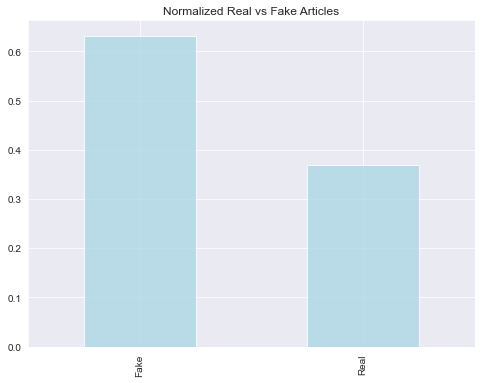

In [15]:
text.label.value_counts(normalize=True).plot(kind='bar', figsize=(8, 6),
                                             color='Lightblue', alpha=0.8, title='Normalized Real vs Fake Articles');

In [16]:
# Note... the length is a character count and not word count
text['len_title'] = text.title.apply(len)
text['len_text'] = text.text.apply(len)

In [17]:
text.len_text[0]

492

In [18]:
text.text[0]

'print they should pay all the back all the money plus interest the entire family and everyone who came in with them need to be deported asap why did it take two years to bust them \nhere we go again another group stealing from the government and taxpayers a group of somalis stole over four million in government benefits over just  months \nweve reported on numerous cases like this one where the muslim refugeesimmigrants commit fraud by scamming our systemits way out of control more related'

In [19]:
real = text.loc[text['label'] == 'Real']
real.type.value_counts()

bias     389
hate     244
state    121
Name: type, dtype: int64

In [20]:
fake = text.loc[text['label'] == 'Fake']
fake.type.value_counts()

bs            599
conspiracy    430
satire        146
junksci       102
fake           15
Name: type, dtype: int64

In [21]:
real.site_url.value_counts()[0:5]

politicususa.com         100
frontpagemag.com          99
presstv.ir                99
returnofkings.com         99
westernjournalism.com     98
Name: site_url, dtype: int64

In [22]:
fake.site_url.value_counts()[0:5]

activistpost.com    100
naturalnews.com     100
awdnews.com         100
infowars.com        100
clickhole.com       100
Name: site_url, dtype: int64

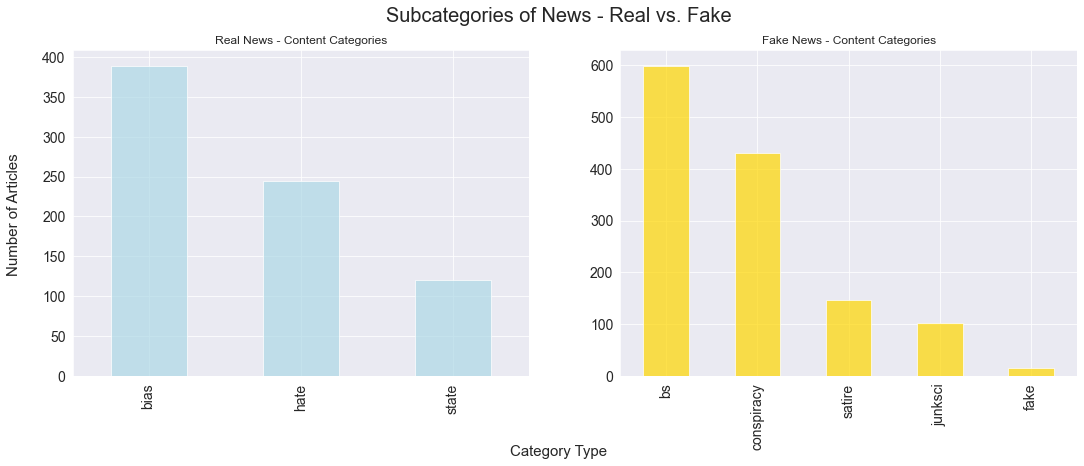

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

real.type.value_counts().plot(kind='bar', ax=axes[0], title='Real News - Content Categories',
                              color='Lightblue', alpha=.7, fontsize=14)
fake.type.value_counts().plot(kind='bar', ax=axes[1], title='Fake News - Content Categories',
                              color='Gold', alpha=.7, fontsize=14)

fig.suptitle('Subcategories of News - Real vs. Fake', fontsize=20)
# ax.set_xlabel('xlabel', fontsize=10)
# plt.ylabel('ylabel', fontsize=16)

# Set common labels
fig.text(0.5, -.05, 'Category Type', ha='center', va='center', fontsize=15)
fig.text(0.08, 0.5, 'Number of Articles', ha='center', va='center', rotation='vertical', fontsize=15);

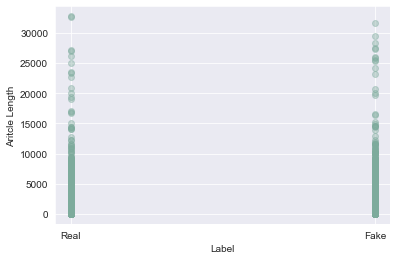

In [24]:
# Create Boxplot
fig = plt.scatter(text.label, text.len_text, alpha=0.4)
plt.xlabel('Label')
plt.ylabel('Aritcle Length');

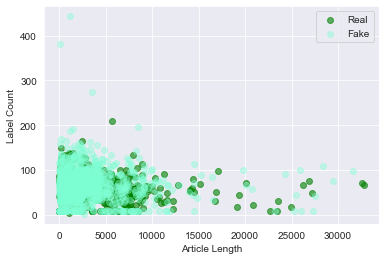

In [25]:
plt.scatter(real.len_text, real.len_title, alpha=0.6, color='green')
plt.scatter(fake.len_text, fake.len_title, alpha=0.4, color='aquamarine')
plt.xlabel('Article Length')
plt.ylabel('Label Count')
plt.legend(['Real', 'Fake']);


In [26]:
(real.len_text).mean()

3209.137931034483

In [27]:
(fake.len_text).mean()

2830.136222910217

On average, the fake articles are slightly shorter.

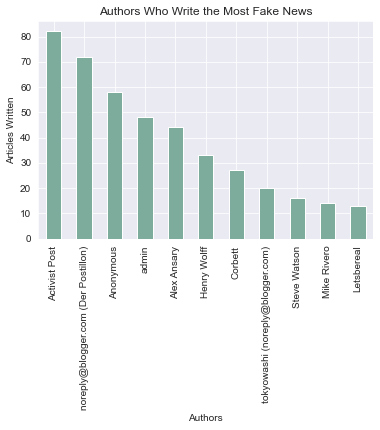

In [28]:
fake_auth_count = fake.author.value_counts()[1:12]
fake_auth_count.plot(kind='bar')
plt.xlabel('Authors')
plt.ylabel('Articles Written')
plt.title('Authors Who Write the Most Fake News')
plt.show()

Top 3 authors of "fake" articles are not tied to real world names.

In [29]:
df.author.value_counts()[1:5]

Activist Post                          82
EdJenner                               73
noreply@blogger.com (Der Postillon)    72
Anonymous                              58
Name: author, dtype: int64

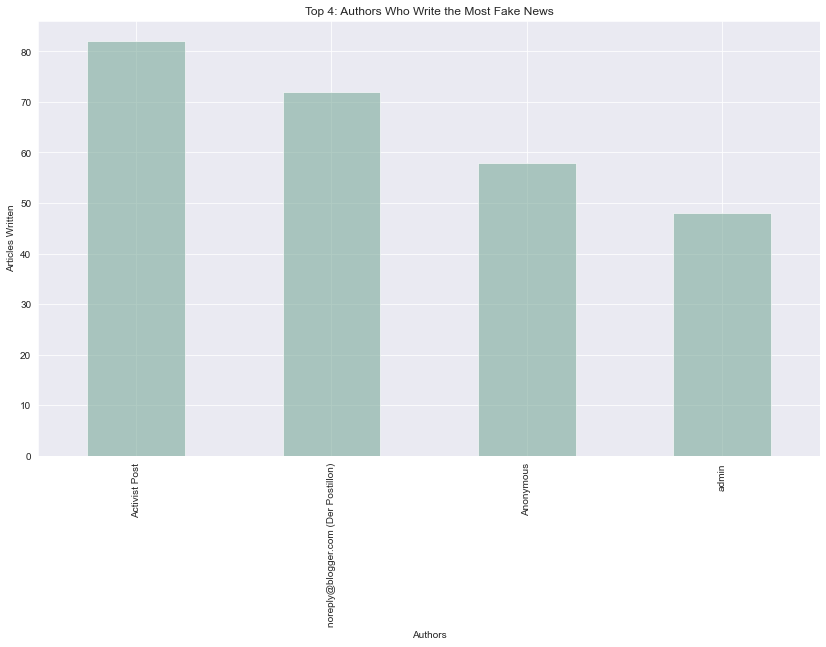

In [30]:
fake.author.value_counts()[1:5].plot(kind='bar', alpha=0.6, figsize=(14,8))
plt.xlabel('Authors')
plt.ylabel('Articles Written')
plt.title('Top 4: Authors Who Write the Most Fake News');

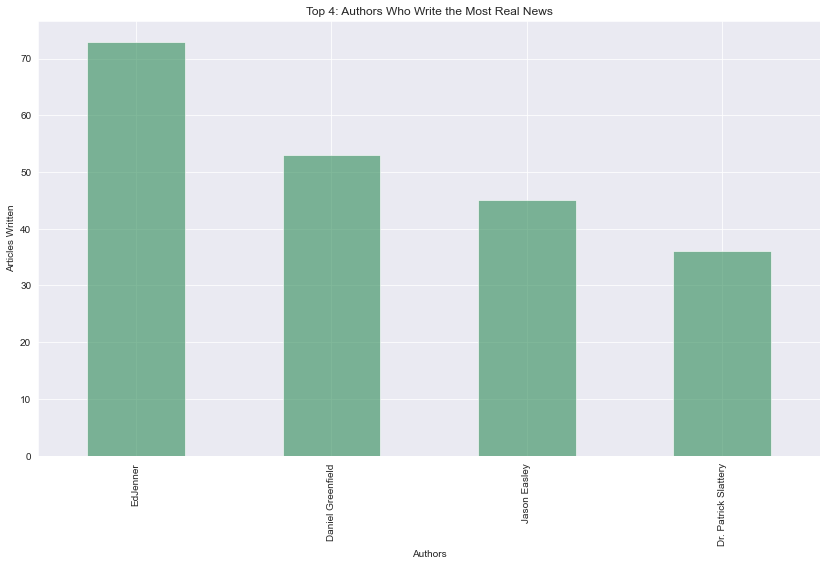

In [31]:
real.author.value_counts()[1:5].plot(kind='bar', color='seagreen', alpha=0.6, figsize=(14, 8))
plt.xlabel('Authors')
plt.ylabel('Articles Written')
plt.title('Top 4: Authors Who Write the Most Real News');

"Real" article authors contrast with the "fake" authors. The most prevalent of authors whose articles were labeled "real" are written under their true name. 

In [32]:
# Look at dates for EDA analyis

In [33]:
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist

import string
stopwords.words('english')[0:10] # Show some stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [34]:
stopwords_list = stopwords.words('english') + list(string.punctuation)
print(stopwords_list)
stopwords_list += ["''", '""', '...', '``']
print(stopwords_list)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [35]:
def process_article(article):
    tokens = nltk.word_tokenize(article)  
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed

In [36]:
processed_data = list(map(process_article, df.text))

In [37]:
real_data = list(map(process_article, real.text))
fake_data = list(map(process_article, fake.text))

In [38]:
# Real text concat
total_vocab_real = set()

for article in real_data:
    total_vocab_real.update(article)
len(total_vocab_real)

articles_concat_real = []
for article in real_data:
    articles_concat_real += article
print(articles_concat_real[0:5])
len(articles_concat_real)

['print', 'pay', 'back', 'money', 'plus']


229511

In [39]:
articles_freqdist_real = FreqDist(articles_concat_real)

In [40]:
# Fake text concat
total_vocab_fake = set()

for article in fake_data:
    total_vocab_fake.update(article)
len(total_vocab_fake)

articles_concat_fake = []
for article in fake_data:
    articles_concat_fake += article
print(articles_concat_fake[0:5])
len(articles_concat_fake)

['st', 'century', 'wire', 'says', 'wire']


350560

In [41]:
articles_freqdist_fake = FreqDist(articles_concat_fake)

In [42]:
total_vocab = set()

for article in processed_data:
    total_vocab.update(article)
len(total_vocab)


47167

In [49]:
articles_concat = []
for article in processed_data:
    articles_concat += article
print(articles_concat[0:5])
len(articles_concat)

['print', 'pay', 'back', 'money', 'plus']


580599

In [50]:
articles_concat[0:5]

['print', 'pay', 'back', 'money', 'plus']

In [51]:
articles_freqdist = FreqDist(articles_concat)
articles_freqdist.most_common(5)

[('trump', 3421),
 ('clinton', 3057),
 ('one', 2414),
 ('us', 2386),
 ('said', 2343)]

In [52]:
top_words = articles_freqdist.most_common(10)

In [53]:
x_val = [x[0] for x in top_words]
y_val = [x[1] for x in top_words]

In [54]:
twords = pd.DataFrame(y_val, index=x_val, columns =['Top_Words']) 

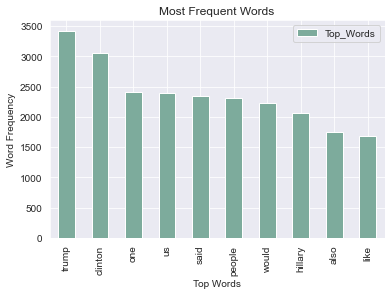

In [55]:
twords.plot(kind='bar')
plt.xlabel('Top Words')
plt.ylabel('Word Frequency')
plt.title('Most Frequent Words')
plt.show()

In [56]:
top_words_real = articles_freqdist_real.most_common(10)
top_words_real

[('trump', 1433),
 ('clinton', 1062),
 ('people', 1035),
 ('us', 1000),
 ('one', 988),
 ('said', 984),
 ('would', 880),
 ('hillary', 782),
 ('also', 662),
 ('like', 661)]

In [57]:
top_words_real = articles_freqdist_real.most_common(10)
x_val_real = [x[0] for x in top_words_real]
y_val_real = [x[1] for x in top_words_real]
twords_real = pd.DataFrame(y_val_real, index=x_val_real, columns =['Top_Words']) 

In [58]:
top_words_fake = articles_freqdist_fake.most_common(10)
x_val_fake = [x[0] for x in top_words_fake]
y_val_fake = [x[1] for x in top_words_fake]
twords_fake = pd.DataFrame(y_val_fake, index=x_val_fake, columns =['Top_Words']) 

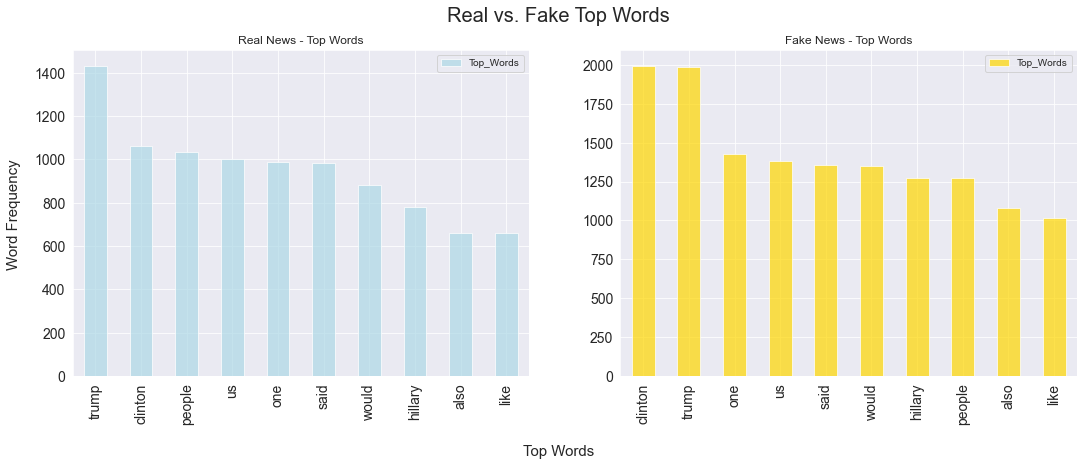

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

twords_real.plot(kind='bar', ax=axes[0], title='Real News - Top Words',
                              color='Lightblue', alpha=.7, fontsize=14)
twords_fake.plot(kind='bar', ax=axes[1], title='Fake News - Top Words',
                              color='Gold', alpha=.7, fontsize=14)

fig.suptitle('Real vs. Fake Top Words', fontsize=20)
# ax.set_xlabel('xlabel', fontsize=10)
# plt.ylabel('ylabel', fontsize=16)

# Set common labels
fig.text(0.5, -.05, 'Top Words', ha='center', va='center', fontsize=15)
fig.text(0.08, 0.5, 'Word Frequency', ha='center', va='center', rotation='vertical', fontsize=15);

In [74]:
def sentiment_calc(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

df['sentiment'] = df['text'].apply(sentiment_calc)

In [75]:
df['sentiment'].head()

0    0.100000
1    0.042381
2    0.183000
3   -0.066667
4    0.176472
Name: sentiment, dtype: float64

In [76]:
def get_sentiment(row):
        if row > 0.1:
            return 'positive'
        elif row < -0.1:
            return 'negative'
        else:
            return 'neutral'

In [77]:
df['sentiment_label'] = df['sentiment'].apply(get_sentiment)

In [78]:
df['sentiment_label'].value_counts()

neutral     1241
positive     690
negative     119
Name: sentiment_label, dtype: int64

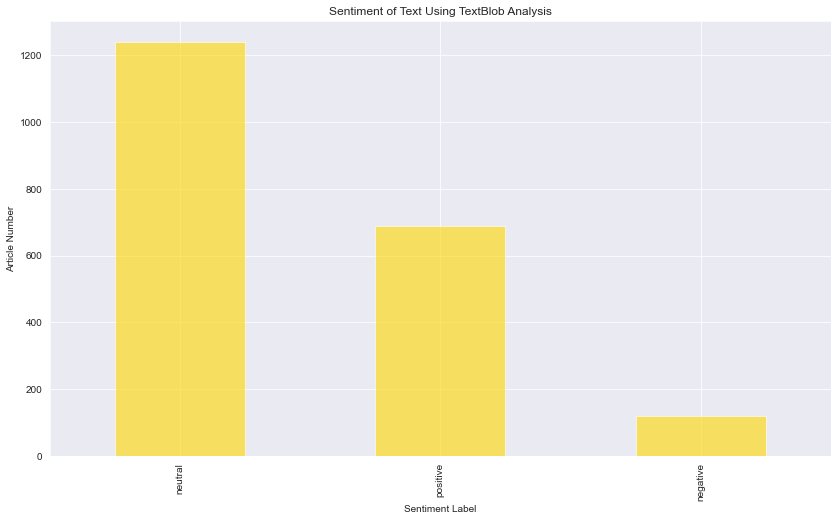

In [79]:
df.sentiment_label.value_counts().plot(kind='bar', color='gold', alpha=0.6, figsize=(14, 8))
plt.xlabel('Sentiment Label')
plt.ylabel('Article Number')
plt.title('Sentiment of Text Using TextBlob Analysis');

In [80]:
def subjectivity_calc(text):
    try:
        return TextBlob(text).sentiment.subjectivity
    except:
        return None

df['subjectivity'] = df['text'].apply(subjectivity_calc)

In [81]:
df['subjectivity'].head()

0    0.405000
1    0.368254
2    0.533667
3    0.916667
4    0.448784
Name: subjectivity, dtype: float64

In [83]:
def get_subjectivity(row):
        if row > 0.75:
            return 'very biased'
        elif row > 0.5 and row < 0.75:
            return 'biased'
        elif row < 0.25:
            return 'very objective'
        else:
            return 'objective'

In [84]:
real['subjectivity'] = real.text_without_stopwords.apply(subjectivity_calc)
real['subjectivity_label'] = real['subjectivity'].apply(get_subjectivity)
real['subjectivity_label'].value_counts()

objective         504
biased            139
very objective     91
very biased        20
Name: subjectivity_label, dtype: int64

In [85]:
fake['subjectivity'] = fake.text_without_stopwords.apply(subjectivity_calc)
fake['subjectivity_label'] = fake['subjectivity'].apply(get_subjectivity)
fake['subjectivity_label'].value_counts()

objective         789
biased            291
very objective    184
very biased        28
Name: subjectivity_label, dtype: int64

In [86]:
real['sentiment'] = real.text_without_stopwords.apply(sentiment_calc)
real['sentiment_label'] = real['subjectivity'].apply(get_sentiment)
real['sentiment_label'].value_counts()

positive    710
neutral      44
Name: sentiment_label, dtype: int64

In [87]:
fake['sentiment'] = fake.text_without_stopwords.apply(sentiment_calc)
fake['sentiment_label'] = fake['subjectivity'].apply(get_sentiment)
fake['sentiment_label'].value_counts()

positive    1179
neutral      113
Name: sentiment_label, dtype: int64

In [88]:
df['subjectivity_label'] = df['subjectivity'].apply(get_subjectivity)

In [89]:
df['subjectivity_label'].value_counts()

objective         1328
biased             456
very objective     218
very biased         48
Name: subjectivity_label, dtype: int64

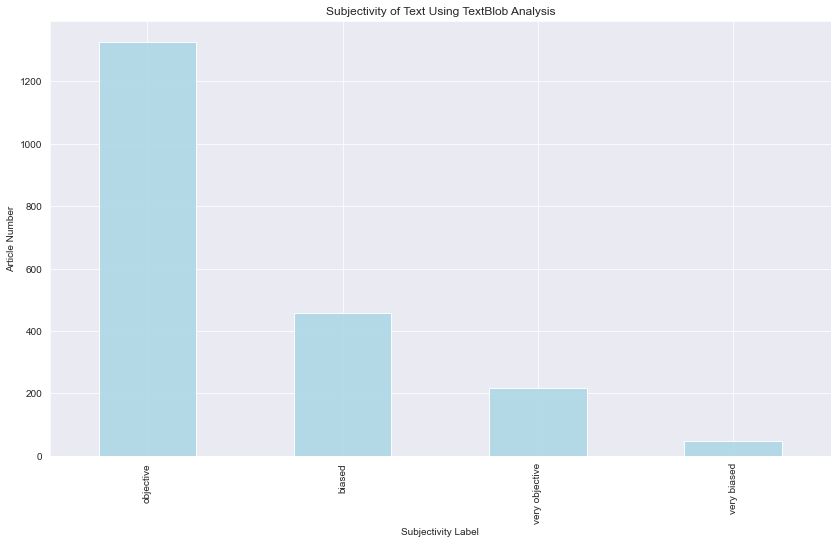

In [90]:
df.subjectivity_label.value_counts().plot(kind='bar', color='lightblue', alpha=0.9, figsize=(14, 8))
plt.xlabel('Subjectivity Label')
plt.ylabel('Article Number')
plt.title('Subjectivity of Text Using TextBlob Analysis');

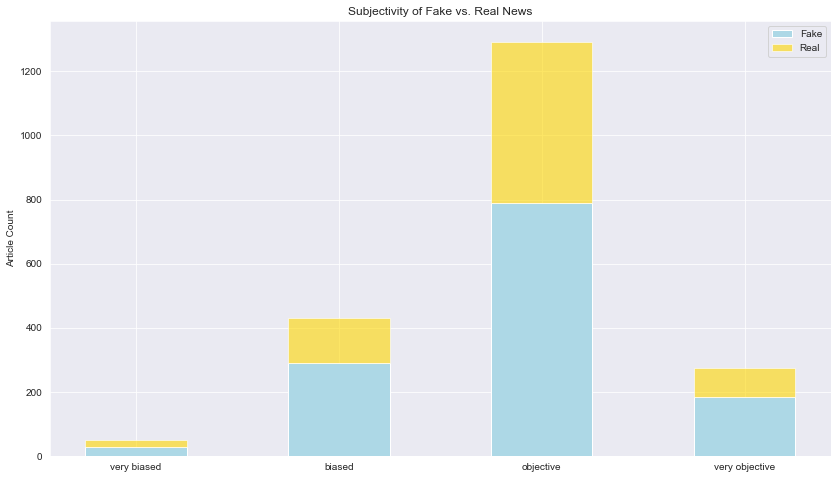

In [92]:

labels = ['very biased', 'biased', 'objective', 'very objective']
fake_sub = [28, 291, 789, 184]
real_sub = [20, 139, 504, 91]
width = 0.50       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(14, 8))

ax.bar(labels, fake_sub, width, label='Fake', color='lightblue')
ax.bar(labels, real_sub, width, bottom=fake_sub, label='Real', color='gold', alpha=0.6)

ax.set_ylabel('Article Count')
ax.set_title('Subjectivity of Fake vs. Real News')
ax.legend()

plt.show()

# Modeling

### TF-IDF & TTS

In [93]:
X = df.text
y = df.label

In [94]:
LE = LabelEncoder()
y = LE.fit_transform(y)

In [95]:
y.sum()

758

In [96]:
len(y)

2050

So 1's are 'real' and 0's are 'fake'.

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=112, test_size=0.2)

In [98]:
print(y_test.shape)
X_train.shape

(410,)


(1640,)

In [99]:
tfidorizer = TfidfVectorizer(stop_words=stopwords_list, ngram_range=(1,3), max_features=200000)

In [100]:
X_train.head()

228     by brandon turbeville in the latest developmen...
831     election rigging and dirty tricks against trum...
1651    the democratization of censorship\n september ...
316     adobochron  comment \nsan francisco california...
632     now its mustards time to shine posted today it...
Name: text, dtype: object

In [101]:
X_train = tfidorizer.fit_transform(X_train)
X_test = tfidorizer.transform(X_test)

In [70]:
# Certain models require dense arrays - TFIDF saves as sparse
X_train_dense = X_train.todense()
X_test_dense = X_test.todense()

In [71]:
print(tfidorizer.get_feature_names()[200:220])

['abandoning', 'abandoning climate', 'abandoning climate change', 'abandoning family', 'abandoning family way', 'abandoning human', 'abandoning human rights', 'abandoning trump', 'abandoning trump embracing', 'abandonment', 'abandonment democracy', 'abandonment democracy honest', 'abandonment human', 'abandonment human rights', 'abandonment material', 'abandonment material struggle', 'abandonment support', 'abandonment support iraq', 'abandons', 'abandons efforts']


... what's an abduction emoji?

### Decision Tree

In [58]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate Tree Classifier
tree = DecisionTreeClassifier()

t0 = time.time()

# Fit classifier - straight out of the box
tree.fit(X_train, y_train)

# Predictions
tree_train_preds = tree.predict(X_train)
tree_test_preds = tree.predict(X_test)

t1 = time.time()
total = t1-t0
print(total,'s\n')

print_metrics(tree_train_preds, y_train, tree_test_preds, y_test)

13.416691064834595 s

Training Model:
----------------
 Precision Score (Train): 100.0%
 Recall Score (Train): 98.86%
 Accuracy Score (Train): 99.57%
 F1 Score (Train): 99.42%
 mAP (Train) Score: 99.28%

Test Model:
----------------
 Precision Score (Test): 62.67%
 Recall Score (Test): 64.38%
 Accuracy Score (Test): 73.66%
 F1 Score (Test): 63.51%
 mAP (Test) Score: 53.03%


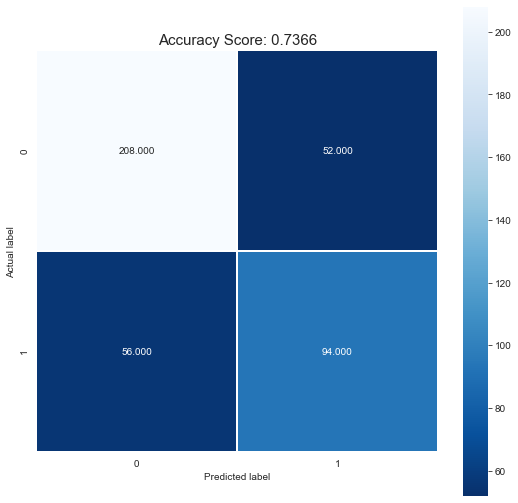

In [61]:
cm = confusion_matrix(tree_test_preds, y_test)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(accuracy_score(y_test, tree_test_preds), 4))
plt.title(all_sample_title, size = 15);

### Logistic Regression

In [72]:
# Instantiating logistic regression classifier model
logreg = LogisticRegression(fit_intercept=False, C=1e5, solver='liblinear')

t0 = time.time()

# Fit the model
logreg.fit(X_train, y_train)
t1=time.time()
total = t1-t0
print(total,'s\n')

# Prediction
lr_train_preds = logreg.predict(X_train)
lr_test_preds = logreg.predict(X_test)

print_metrics(lr_train_preds, y_train, lr_test_preds, y_test)

3.834934949874878 s

Training Model:
----------------
 Precision Score (Train): 99.51%
 Recall Score (Train): 99.35%
 Accuracy Score (Train): 99.57%
 F1 Score (Train): 99.43%
 mAP (Train) Score: 99.1%

Test Model:
----------------
 Precision Score (Test): 78.95%
 Recall Score (Test): 51.37%
 Accuracy Score (Test): 77.8%
 F1 Score (Test): 62.24%
 mAP (Test) Score: 57.87%


... speedy McGee

Below is a Logistic Regression model that sacrifices Accuracy for High-Precision (with a smaller lambda):

In [114]:
# Instantiating logistic regression classifier model
logreg = LogisticRegression(fit_intercept=True, C=1, solver='liblinear')

t0 = time.time()

# Fit the model
logreg.fit(X_train, y_train)
t1=time.time()
total = t1-t0
print(total,'s\n')

# Prediction
lr_train_preds = logreg.predict(X_train)
lr_test_preds = logreg.predict(X_test)

print_metrics(lr_train_preds, y_train, lr_test_preds, y_test)

0.1264958381652832 s

Training Model:
----------------
 Precision Score (Train): 99.29%
 Recall Score (Train): 68.95%
 Accuracy Score (Train): 88.23%
 F1 Score (Train): 81.39%
 mAP (Train) Score: 80.05%

Test Model:
----------------
 Precision Score (Test): 95.24%
 Recall Score (Test): 27.4%
 Accuracy Score (Test): 73.66%
 F1 Score (Test): 42.55%
 mAP (Test) Score: 51.95%


Here is an attempt at a different solver... not as strong and long run time...

In [95]:
# Instantiating logistic regression classifier model
logreg = LogisticRegression(fit_intercept=True, C=1e5, solver='saga', penalty='elasticnet', l1_ratio=0.5)

t0 = time.time()

# Fit the model
logreg.fit(X_train, y_train)
t1=time.time()
total = t1-t0
print(total,'s\n')

# Prediction
lr_train_preds = logreg.predict(X_train)
lr_test_preds = logreg.predict(X_test)

print_metrics(lr_train_preds, y_train, lr_test_preds, y_test)

210.9694221019745 s

Training Model:
----------------
 Precision Score (Train): 99.84%
 Recall Score (Train): 99.02%
 Accuracy Score (Train): 99.57%
 F1 Score (Train): 99.43%
 mAP (Train) Score: 99.22%

Test Model:
----------------
 Precision Score (Test): 82.29%
 Recall Score (Test): 54.11%
 Accuracy Score (Test): 79.51%
 F1 Score (Test): 65.29%
 mAP (Test) Score: 60.87%


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Below is the best Logistic Regression model based on overall Accuracy and F-1 Score:

In [116]:
# Instantiating logistic regression classifier model
# Adjusting intercept fit to True, based on gridsearch
logreg = LogisticRegression(fit_intercept=True, C=1e5, solver='liblinear')

t0 = time.time()

# Fit the model
logreg.fit(X_train, y_train)
t1=time.time()
total = t1-t0
print(total,'s\n')

# Prediction
lr_train_preds = logreg.predict(X_train)
lr_test_preds = logreg.predict(X_test)

print_metrics(lr_train_preds, y_train, lr_test_preds, y_test)

0.5105080604553223 s

Training Model:
----------------
 Precision Score (Train): 99.67%
 Recall Score (Train): 99.18%
 Accuracy Score (Train): 99.57%
 F1 Score (Train): 99.43%
 mAP (Train) Score: 99.16%

Test Model:
----------------
 Precision Score (Test): 81.82%
 Recall Score (Test): 61.64%
 Accuracy Score (Test): 81.46%
 F1 Score (Test): 70.31%
 mAP (Test) Score: 64.09%


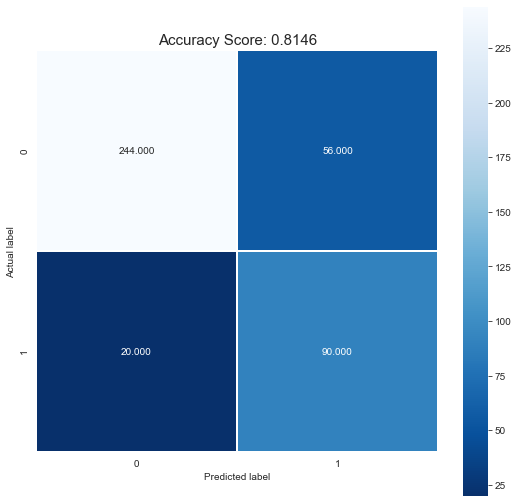

In [117]:
cm = confusion_matrix(lr_test_preds, y_test)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(accuracy_score(y_test, lr_test_preds), 4))
plt.title(all_sample_title, size = 15);

In [ ]:
fit_intercept=True, C=1e5, solver='liblinear'

In [124]:
# Parameters for optimization
lr_params = {
    'fit_intercept': [True],
    'C': [1e5],
    'solver': ['liblinear'],
}

In [125]:
t0 = time.time()

gs_lr = GridSearchCV(logreg, lr_params, cv=3)

gs_lr.fit(X_train, y_train)

print(f"Training Accuracy: {gs_lr.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {gs_lr.best_params_}")

t1 = time.time()
total = t1-t0
print('\n',total,'s\n')

lr_score = (gs_lr.score(X_test, y_test)*100)

print('Logistic Regression Grid Search: {}%'.format((round(lr_score, 2))))

Training Accuracy: 73.48%

Optimal Parameters: {'C': 100000.0, 'fit_intercept': True, 'solver': 'liblinear'}

 1.1614000797271729 s

Logistic Regression Grid Search: 81.46%


LogReg actually had the highest out-of-box score and fastest run time. At first I was disappointed since it's not a "sexy" algorithm... but then I realized, this is great for practical purposes! Adjusting the C-parameter to reduce regularization penalty improved accuracy (worsened precision, improved recall). Liblnear has the highest score and fastest run time.

We'll see how things change as I tune parameters and after running SMOTE/PCA/more NLP.


### Gaussian Naive Bayes

In [118]:
# Instantiating Naive Bayes classifier
nb_classifier = GaussianNB()

t0 = time.time()

# Fit NB classifier
nb_classifier.fit(X_train_dense, y_train)
t1 = time.time()
total = t1-t0
print(total,'s\n')

# Fortune telling...
nb_train_preds = nb_classifier.predict(X_train_dense)
nb_test_preds = nb_classifier.predict(X_test_dense)

print_metrics(nb_train_preds, y_train, nb_test_preds, y_test)

175.41547894477844 s

Training Model:
----------------
 Precision Score (Train): 97.45%
 Recall Score (Train): 100.0%
 Accuracy Score (Train): 99.02%
 F1 Score (Train): 98.71%
 mAP (Train) Score: 97.45%

Test Model:
----------------
 Precision Score (Test): 72.22%
 Recall Score (Test): 53.42%
 Accuracy Score (Test): 76.1%
 F1 Score (Test): 61.42%
 mAP (Test) Score: 55.17%


Base models are performing well on the training sets but overfitting as seen by the lower testing accuracy. 

There are severe democratic implications when considering we may validate disinformation as truth OR silence truth by labeling it as disinformation. Therefore, precision vs. recall is not an easy decision. In the context of our problem - classifying in conjunction with a recommendation system - precision (along with accuracy) is likely the better metric. It would be dangerous to validate fake information as real. 

Note: Decision Tree/Log Reg is performing better than Naive Bayes out-of-the-box with a significantly less run time (and memory footprint) since it can take in sparse arrays. This is important when we have 342,000+ columns.

### Random Forest

In [119]:
# Onto the ensembles... instantiate random forest
rf_classifier = RandomForestClassifier(n_estimators=100)

t0 = time.time()
# Fit Random Forest
rf_classifier.fit(X_train, y_train)
t1 = time.time()

total = t1-t0
print(total,'s')


# Prediction time
rf_train_preds = rf_classifier.predict(X_train)
rf_test_preds = rf_classifier.predict(X_test)

print_metrics(rf_train_preds, y_train, rf_test_preds, y_test)

16.69704508781433 s
Training Model:
----------------
 Precision Score (Train): 99.67%
 Recall Score (Train): 99.18%
 Accuracy Score (Train): 99.57%
 F1 Score (Train): 99.43%
 mAP (Train) Score: 99.16%

Test Model:
----------------
 Precision Score (Test): 91.67%
 Recall Score (Test): 45.21%
 Accuracy Score (Test): 79.02%
 F1 Score (Test): 60.55%
 mAP (Test) Score: 60.95%


Random Forest has the highest precision on the test set - may be the go to if we want to have the lowest number of false positives (labeled real when it is not real).

#### GridSearch - RF

In [120]:
# Parameters for optimization
rf_params = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [123]:

t0 = time.time()

gs_rf = GridSearchCV(rf_classifier, rf_params, cv=3)

gs_rf.fit(X_train, y_train)

print(f"Training Accuracy: {gs_rf.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {gs_rf.best_params_}")

t1 = time.time()
total = t1-t0
print('\n',total,'s\n')

rf_score = (gs_rf.score(X_test, y_test)*100)

print('Random forest grid search: {}%'.format((round(rf_score, 2))))

Training Accuracy: 73.41%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 200}

 442.16133999824524 s

Random forest grid search: 77.56%


In [111]:
# Optimized RF classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_leaf=3, 
                                       min_samples_split=10, n_estimators=200)

t0 = time.time()
# Fit Random Forest
rf_classifier.fit(X_train, y_train)
t1 = time.time()

total = t1-t0
print(total,'s')


# Prediction time
rf_train_preds = rf_classifier.predict(X_train)
rf_test_preds = rf_classifier.predict(X_test)

print_metrics(rf_train_preds, y_train, rf_test_preds, y_test)

5.234730005264282 s
Training Model:
----------------
 Precision Score (Train): 99.21%
 Recall Score (Train): 82.35%
 Accuracy Score (Train): 93.17%
 F1 Score (Train): 90.0%
 mAP (Train) Score: 88.29%

Test Model:
----------------
 Precision Score (Test): 96.36%
 Recall Score (Test): 36.3%
 Accuracy Score (Test): 76.83%
 F1 Score (Test): 52.74%
 mAP (Test) Score: 57.66%


Optimized parameters performed worse...

Random Forest ran well enough but falls short of SVM.

### Gradient Boost

#### ... need more powaaaa

In [72]:
from sklearn.ensemble import GradientBoostingClassifier

In [73]:
# Instantiate an GradientBoostingClassifier
gbt_clf = GradientBoostingClassifier(random_state=23)

t0 = time.time()

# Fit GradientBoostingClassifier
gbt_clf.fit(X_train, y_train)

t1 = time.time()
total = t1-t0
print('\n',total,'s\n')

# GradientBoosting model predictions
gbt_train_preds = gbt_clf.predict(X_train)
gbt_test_preds = gbt_clf.predict(X_test)

# Scores
print_metrics(gbt_train_preds, y_train, gbt_test_preds, y_test)


 50.31204700469971 s

Training Model:
----------------
 Precision Score (Train): 98.87%
 Recall Score (Train): 71.24%
 Accuracy Score (Train): 88.96%
 F1 Score (Train): 82.81%
 mAP (Train) Score: 81.17%

Test Model:
----------------
 Precision Score (Test): 78.57%
 Recall Score (Test): 52.74%
 Accuracy Score (Test): 78.05%
 F1 Score (Test): 63.11%
 mAP (Test) Score: 58.27%


#### GridSearch - Gradient Boost

In [74]:
# Parameters for optimization
gb_params = {
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth":[3,5,8],
    "criterion": ["friedman_mse"],
    "subsample":[0.5, 0.8, 0.9, 1.0],
    "n_estimators":[50, 100, 200]
    }

In [76]:
t0 = time.time()

gs_gb = GridSearchCV(gbt_clf, gb_params, n_jobs=-1)

gs_gb.fit(X_train, y_train)

print(f"Training Accuracy: {gs_gb.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {gs_gb.best_params_}")

t1 = time.time()
total = t1-t0
print('\n',total,'s\n')

gb_score = (gs_gb.score(X_test, y_test)*100)

print('Gradient Boosting grid search: {}%'.format((round(rf_score, 2))))

Training Accuracy: 78.35%

Optimal Parameters: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.9}

 21521.1594748497 s

Gradient Boosting grid search: 78.29%


Found slightly better parameters for Gradient Boosting but considering computation costs and worse performance than SVM, will rule out Gradient Boosting.

P.S. The previous gradient search I ran was going for 40 hours before I stopped it...

## XGBoost

In [102]:
# Instantiate XGBClassifier
xgb_clf = XGBClassifier()

t0 = time.time()
# Fit XGBClassifier
xgb_clf.fit(X_train, y_train)

t1 = time.time()
total = t1-t0
print('\n',total,'s\n')

# Predict on training and test sets
xgb_train_preds = xgb_clf.predict(X_train)
xgb_test_preds = xgb_clf.predict(X_test)

print_metrics(xgb_train_preds, y_train, xgb_test_preds, y_test)

[22:34:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 15.27504277229309 s

Training Model:
----------------
 Precision Score (Train): 99.33%
 Recall Score (Train): 96.73%
 Accuracy Score (Train): 98.54%
 F1 Score (Train): 98.01%
 mAP (Train) Score: 97.3%

Test Model:
----------------
 Precision Score (Test): 79.46%
 Recall Score (Test): 60.96%
 Accuracy Score (Test): 80.49%
 F1 Score (Test): 68.99%
 mAP (Test) Score: 62.34%


Tried tuning XGBoost, but it's clearly smarter than me and best out-of-the box.

## SVM

In [102]:
# Instantiate SVM 
svm_clf = SVC(kernel='linear', C=100) 

t0 = time.time()

# Fit SVM classifier
svm_clf.fit(X_train, y_train)

t1 = time.time()
total = t1-t0
print('\n',total,'s\n')

# Predictions
svm_train_preds = svm_clf.predict(X_train)
svm_test_preds = svm_clf.predict(X_test)

print_metrics(svm_train_preds, y_train, svm_test_preds, y_test)


 5.858343124389648 s

Training Model:
----------------
 Precision Score (Train): 99.83%
 Recall Score (Train): 98.86%
 Accuracy Score (Train): 99.51%
 F1 Score (Train): 99.34%
 mAP (Train) Score: 99.12%

Test Model:
----------------
 Precision Score (Test): 77.97%
 Recall Score (Test): 63.01%
 Accuracy Score (Test): 80.49%
 F1 Score (Test): 69.7%
 mAP (Test) Score: 62.3%


In [103]:
# Instantiate SVM 
svm_clf = SVC(kernel='sigmoid', C=500) 

t0 = time.time()

# Fit SVM classifier
svm_clf.fit(X_train, y_train)

t1 = time.time()
total = t1-t0
print('\n',total,'s\n')

# Predictions
svm_train_preds = svm_clf.predict(X_train)
svm_test_preds = svm_clf.predict(X_test)

print_metrics(svm_train_preds, y_train, svm_test_preds, y_test)


 5.152868747711182 s

Training Model:
----------------
 Precision Score (Train): 99.51%
 Recall Score (Train): 99.02%
 Accuracy Score (Train): 99.45%
 F1 Score (Train): 99.26%
 mAP (Train) Score: 98.9%

Test Model:
----------------
 Precision Score (Test): 73.68%
 Recall Score (Test): 67.12%
 Accuracy Score (Test): 79.76%
 F1 Score (Test): 70.25%
 mAP (Test) Score: 61.17%


In [105]:
# Instantiate SVM 
svm_clf = SVC(kernel='sigmoid', C=100) 

t0 = time.time()

# Fit SVM classifier
svm_clf.fit(X_train, y_train)

t1 = time.time()
total = t1-t0
print('\n',total,'s\n')

# Predictions
svm_train_preds = svm_clf.predict(X_train)
svm_test_preds = svm_clf.predict(X_test)

print_metrics(svm_train_preds, y_train, svm_test_preds, y_test)


 5.338248014450073 s

Training Model:
----------------
 Precision Score (Train): 99.51%
 Recall Score (Train): 98.86%
 Accuracy Score (Train): 99.39%
 F1 Score (Train): 99.18%
 mAP (Train) Score: 98.8%

Test Model:
----------------
 Precision Score (Test): 77.87%
 Recall Score (Test): 65.07%
 Accuracy Score (Test): 80.98%
 F1 Score (Test): 70.9%
 mAP (Test) Score: 63.11%


In [113]:
# Instantiate SVM 
svm_clf = SVC(kernel='sigmoid', C=50, gamma='scale', class_weight='balanced')

t0 = time.time()

# Fit SVM classifier
svm_clf.fit(X_train, y_train)

t1 = time.time()
total = t1-t0
print('\n',total,'s\n')

# Predictions
svm_train_preds = svm_clf.predict(X_train)
svm_test_preds = svm_clf.predict(X_test)

print_metrics(svm_train_preds, y_train, svm_test_preds, y_test)


 5.327059030532837 s

Training Model:
----------------
 Precision Score (Train): 98.08%
 Recall Score (Train): 100.0%
 Accuracy Score (Train): 99.27%
 F1 Score (Train): 99.03%
 mAP (Train) Score: 98.08%

Test Model:
----------------
 Precision Score (Test): 80.67%
 Recall Score (Test): 65.75%
 Accuracy Score (Test): 82.2%
 F1 Score (Test): 72.45%
 mAP (Test) Score: 65.24%


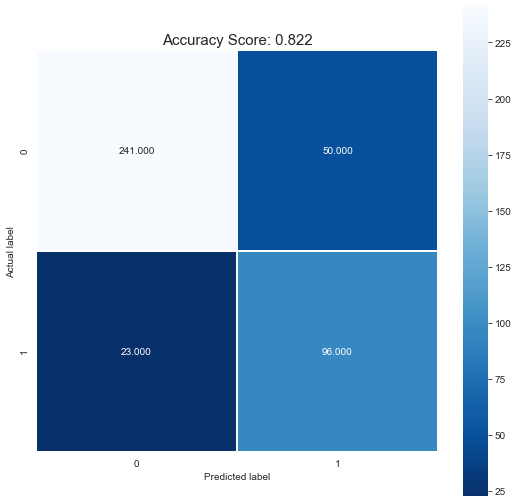

In [224]:
cm = confusion_matrix(svm_test_preds, y_test)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(accuracy_score(y_test, svm_test_preds), 4))
plt.title(all_sample_title, size = 15);

After tuning, specifically with sigmoid-kernel, SVM is performing the best of any model at a relatively fast speed.

# Re-NLP | PCA | SMOTE

In [103]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [104]:
get_top_n_bigram(df.text, 5)

[('of the', 6062),
 ('in the', 4610),
 ('to the', 2807),
 ('on the', 1838),
 ('and the', 1800)]

In [105]:
get_top_n_trigram(df.text, 5)

[('the united states', 460),
 ('one of the', 366),
 ('as well as', 243),
 ('the white house', 232),
 ('according to the', 208)]

In [106]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" } 

In [107]:
import codecs
import unidecode
import re
import spacy
nlp = spacy.load('en')

def spacy_cleaner(text):
    try:
        decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
    except:
        decoded = unidecode.unidecode(text)
    apostrophe_handled = re.sub("’", "'", decoded)
    expanded = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in apostrophe_handled.split(" ")])
    parsed = nlp(expanded)
    final_tokens = []
    for t in parsed:
        if t.is_punct or t.is_space or t.like_num or t.like_url or str(t).startswith('@'):
            pass
        else:
            if t.lemma_ == '-PRON-':
                final_tokens.append(str(t))
            else:
                sc_removed = re.sub("[^a-zA-Z]", '', str(t.lemma_))
                if len(sc_removed) > 1:
                    final_tokens.append(sc_removed)
    joined = ' '.join(final_tokens)
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    return spell_corrected

In [68]:
df.text[:10]

0    print they should pay all the back all the mon...
1    why did attorney general loretta lynch plead t...
2    red state  \nfox news sunday reported this mor...
3    email kayla mueller was a prisoner and torture...
4    email healthcare reform to make america great ...
5    print hillary goes absolutely berserk she expl...
6    breaking nypd ready to make arrests in weiner ...
7    breaking nypd ready to make arrests in weiner ...
8    limbaugh said that the revelations in the wiki...
9    email \nthese people are sick and evil they wi...
Name: text, dtype: object

In [108]:
[spacy_cleaner(t) for t in df.text[:2]]

['print they should pay all the back all the money plus interest the entire family and everyone who come in with them need to be deport asap why do it take year to bust them here we go again another group steal from the government and taxpayer group of somalis steal over in government benefit over just month we have report on numerous case like this where the muslim refugeesimmigrant commit fraud by scamme our systemit way out of control more related',
 'why do attorney general loretta lynch plead the barracuda brigade print the administration be block congressional probe into cash payment to iran of course she need to plead the th she either can not recall refuse to answer or just plain deflect the question straight up corruption at its fine percentfedupcom talk about cover your ass loretta lynch do just that when she plead the to avoid incriminate herself over payment to irancorrupt to the core attorney general loretta lynch be decline to comply with an investigation by lead member o

In [70]:
df['clean_text'] = [spacy_cleaner(t) for t in df.text]

In [123]:
tvec = TfidfVectorizer(stop_words=None, max_features=125000, ngram_range=(1, 3))
lr = LogisticRegression(fit_intercept=True, C=1e6, solver='liblinear')

from sklearn.model_selection import StratifiedKFold

def lr_cv(splits, X, Y, pipeline, average_method):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        lr_fit = pipeline.fit(X[train], Y[train])
        prediction = lr_fit.predict(X[test])
        scores = lr_fit.score(X[test],Y[test])
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        print('               Fake        Real')
        print('precision:',precision_score(Y[test], prediction, average=None))
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        print('recall:   ',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('f1 score: ',f1_score(Y[test], prediction, average=None))
        print('-'*50)

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))

In [124]:
from sklearn.pipeline import Pipeline
original_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', lr)
])
lr_cv(5, df.clean_text, df.label, original_pipeline, 'macro')

               Fake        Real
precision: [0.80073801 0.70503597]
recall:    [0.84108527 0.64473684]
f1 score:  [0.82041588 0.67353952]
--------------------------------------------------
               Fake        Real
precision: [0.78518519 0.67142857]
recall:    [0.82170543 0.61842105]
f1 score:  [0.8030303  0.64383562]
--------------------------------------------------
               Fake        Real
precision: [0.77319588 0.72268908]
recall:    [0.87209302 0.56578947]
f1 score:  [0.81967213 0.63468635]
--------------------------------------------------
               Fake        Real
precision: [0.80338983 0.80869565]
recall:    [0.91505792 0.61589404]
f1 score:  [0.85559567 0.69924812]
--------------------------------------------------
               Fake        Real
precision: [0.80276817 0.7768595 ]
recall:    [0.8957529  0.62251656]
f1 score:  [0.84671533 0.69117647]
--------------------------------------------------
accuracy: 77.46% (+/- 2.21%)
precision: 76.50% (+/- 2.86%)
r

In [95]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

In [96]:
SMOTE_pipeline = make_pipeline(tvec, SMOTE(random_state=777),lr)

In [97]:
sent1 = "I love dogs"
sent2 = "I don't like dogs"
sent3 = "I adore cats"
sent4 = "I hate spiders"
sent5 = "I like dogs"
testing_text = pd.Series([sent1, sent2, sent3, sent4, sent5])
testing_target = pd.Series([1,0,1,0,1])

In [113]:
tv = TfidfVectorizer(stop_words=None, max_features=150000)
testing_tfidf = tv.fit_transform(testing_text)

In [99]:
smt = SMOTE(random_state=777, k_neighbors=1)
X_SMOTE, y_SMOTE = smt.fit_sample(testing_tfidf, testing_target)
pd.DataFrame(X_SMOTE.todense(), columns=tv.get_feature_names())

,adore,cats,dogs,don,hate,like,love,spiders
0,0.000000,0.000000,0.556451,0.000000,0.000000,0.000000,0.830881,0.000000
1,0.000000,0.000000,0.462208,0.690159,0.000000,0.556816,0.000000,0.000000
2,0.707107,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.707107,0.000000,0.000000,0.707107
4,0.000000,0.000000,0.638711,0.000000,0.000000,0.769447,0.000000,0.000000
5,0.000000,0.000000,0.298794,0.446153,0.249998,0.359954,0.000000,0.249998


In [121]:
lr_cv(5, df.clean_text, df.label, SMOTE_pipeline, 'macro')

               Fake        Real
precision: [0.79562044 0.70588235]
recall:    [0.84496124 0.63157895]
f1 score:  [0.81954887 0.66666667]
--------------------------------------------------
               Fake        Real
precision: [0.77906977 0.625     ]
recall:    [0.77906977 0.625     ]
f1 score:  [0.77906977 0.625     ]
--------------------------------------------------
               Fake        Real
precision: [0.76530612 0.71551724]
recall:    [0.87209302 0.54605263]
f1 score:  [0.81521739 0.61940299]
--------------------------------------------------
               Fake        Real
precision: [0.81228669 0.82051282]
recall:    [0.91891892 0.63576159]
f1 score:  [0.86231884 0.71641791]
--------------------------------------------------
               Fake        Real
precision: [0.80714286 0.74615385]
recall:    [0.87258687 0.64238411]
f1 score:  [0.83858998 0.69039146]
--------------------------------------------------
accuracy: 76.83% (+/- 3.15%)
precision: 75.72% (+/- 3.81%)
r

LogisticRegression(C=1000000.0, solver='liblinear')


Validation result for 10000 features
null accuracy: 64.39%
accuracy score: 77.56%
model is 13.17% more accurate than null accuracy
train and test time: 1.05s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 64.39%
accuracy score: 78.29%
model is 13.90% more accurate than null accuracy
train and test time: 0.93s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 64.39%
accuracy score: 78.05%
model is 13.66% more accurate than null accuracy
train and test time: 1.06s
--------------------------------------------------------------------------------
Validation result for 40000 features
null accuracy: 64.39%
accuracy score: 78.78%
model is 14.39% more accurate than null accuracy
train and test time: 1.03s
-----------------------------------------------------------------------

null accuracy: 64.39%
accuracy score: 81.71%
model is 17.32% more accurate than null accuracy
train and test time: 10.72s
--------------------------------------------------------------------------------
Validation result for 120000 features
null accuracy: 64.39%
accuracy score: 81.95%
model is 17.56% more accurate than null accuracy
train and test time: 9.36s
--------------------------------------------------------------------------------


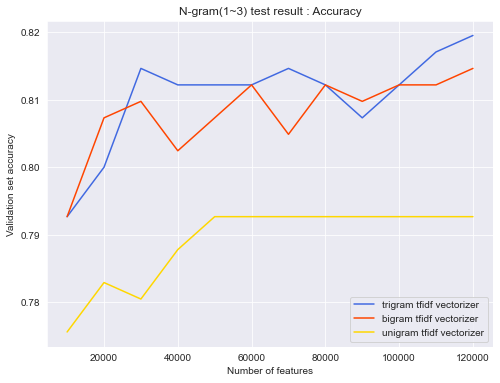

In [143]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time

cvec = CountVectorizer()
tvec = TfidfVectorizer()
lr = LogisticRegression(fit_intercept=True, C=1e6, solver='liblinear')
n_features = np.arange(10000,120001,10000)

def nfeature_accuracy_checker(vectorizer=tvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,nfeature_accuracy,tt_time))
    return result

feature_result_ugt = nfeature_accuracy_checker(vectorizer=tvec)
feature_result_bgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))


nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
# plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
# plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
# plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [152]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD


In [164]:
tvec = TfidfVectorizer(stop_words=None, max_features=125000, ngram_range=(1, 3))
lr = LogisticRegression(fit_intercept=True, C=1e6, solver='liblinear')

pca_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('svd', TruncatedSVD(n_components=100)),
    ('classifier', lr)
])
lr_cv(5, df.text, df.label, pca_pipeline, 'macro')

               Fake        Real
precision: [0.75247525 0.71962617]
recall:    [0.88372093 0.50657895]
f1 score:  [0.81283422 0.59459459]
--------------------------------------------------
               Fake        Real
precision: [0.72222222 0.64423077]
recall:    [0.85658915 0.44078947]
f1 score:  [0.78368794 0.5234375 ]
--------------------------------------------------
               Fake        Real
precision: [0.71384615 0.69411765]
recall:    [0.89922481 0.38815789]
f1 score:  [0.79588336 0.4978903 ]
--------------------------------------------------
               Fake        Real
precision: [0.73148148 0.74418605]
recall:    [0.91505792 0.42384106]
f1 score:  [0.81303602 0.54008439]
--------------------------------------------------
               Fake        Real
precision: [0.73548387 0.69      ]
recall:    [0.88030888 0.45695364]
f1 score:  [0.80140598 0.5498008 ]
--------------------------------------------------
accuracy: 72.29% (+/- 1.52%)
precision: 71.48% (+/- 2.05%)
r

In [162]:
tvec = TfidfVectorizer(stop_words=None, max_features=125000, ngram_range=(1, 3))
lr = LogisticRegression(fit_intercept=True, C=1e6, solver='liblinear')

pca_pipeline = Pipeline([
    ('vectorizer', tvec),
#     ('svd', TruncatedSVD(n_components=1000)),
    ('classifier', lr)
])
lr_cv(5, df.text, df.label, pca_pipeline, 'macro')

               Fake        Real
precision: [0.79496403 0.71969697]
recall:    [0.85658915 0.625     ]
f1 score:  [0.82462687 0.66901408]
--------------------------------------------------
               Fake        Real
precision: [0.79272727 0.7037037 ]
recall:    [0.84496124 0.625     ]
f1 score:  [0.81801126 0.66202091]
--------------------------------------------------
               Fake        Real
precision: [0.78767123 0.76271186]
recall:    [0.89147287 0.59210526]
f1 score:  [0.83636364 0.66666667]
--------------------------------------------------
               Fake        Real
precision: [0.81481481 0.84955752]
recall:    [0.93436293 0.63576159]
f1 score:  [0.8705036  0.72727273]
--------------------------------------------------
               Fake        Real
precision: [0.80851064 0.7578125 ]
recall:    [0.88030888 0.64238411]
f1 score:  [0.84288355 0.6953405 ]
--------------------------------------------------
accuracy: 78.63% (+/- 2.14%)
precision: 77.92% (+/- 2.92%)
r

In [ ]:
 ('pca', PCA(n_components=100))

In [ ]:
svd = TruncatedSVD(n_components=5, random_state=42)
data = svd.fit_transform(data) 